In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from itertools import izip
from scipy.stats import norm

# to show plots:
get_ipython().magic(u'pylab inline')

get_ipython().magic(u'load_ext autoreload')
get_ipython().magic(u'autoreload 2')

# get_ipython().magic(u"config InlineBackend.figure_formats = 'png', 'pdf'")
get_ipython().magic(u"config InlineBackend.figure_formats = 'png', ")

mpl.rcParams['figure.figsize'] = (7.0, 5.0)  # default size of plots
mpl.rcParams['axes.labelsize'] = 24
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['xtick.minor.size'] = 5
mpl.rcParams['ytick.minor.size'] = 5
mpl.rcParams['legend.framealpha'] = 0.6
mpl.rcParams['legend.fontsize'] = 18
mpl.rcParams['legend.scatterpoints'] = 1
# mpl.rcParams['legend.fancybox'] = 1
mpl.rcParams.update({'font.size': 24, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


#Resolution matters 

## Single reference jet pT

Let's try a simple MC experiment. Take lots of reference jets with a single pT, and then generate L1 jets from them by randomly sampling a normal distribution with centre = true jet pT, and playing around with the width (the width of the Gaussian used to simulate L1 jet pTs) Basically we imagine we have a set of matching jets, where all the ref jets have the same pT:

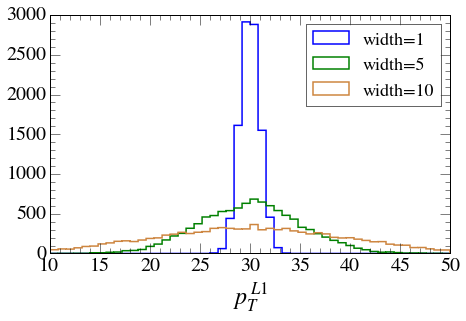

In [2]:
true_pt = 30.0
N = 10000
l1jets_1 = np.random.normal(loc=true_pt, scale=1, size=N)
l1jets_5 = np.random.normal(loc=true_pt, scale=5, size=N)
l1jets_10 = np.random.normal(loc=true_pt, scale=10, size=N)
plt.hist(l1jets_1, bins=50, range=[10,50], normed=False, label='width=1', 
         histtype="step", linewidth=1.5)
plt.hist(l1jets_5, bins=50, color='green', range=[10,50], normed=False, label='width=5', 
         histtype="step", linewidth=1.5)
plt.hist(l1jets_10, bins=50, color='peru', range=[10,50], normed=False, label='width=10', 
         histtype="step", linewidth=1.5)
plt.xlabel(r"$p_T^{L1}$")
plt.minorticks_on()
plt.tight_layout()
plt.legend()
# plt.yscale('log')

Now we caclulate the resolution distribution and fit a Guassian to it:

In [3]:
# calculate resolution = (L1 - ref )/ L1 = 1 - (ref/L1)
refjets = np.array([true_pt]*N)
res_1 = np.ones(N)-np.divide(refjets, l1jets_1)
res_5 = np.ones(N)-np.divide(refjets, l1jets_5)
res_10 = np.ones(N)-np.divide(refjets, l1jets_10)

width = 1: N: 1991.39796336 mean: 0.000165802762744 sigma: -0.0334295391004 should be: 0.0333333333333
width = 5: N: 408.944801571 mean: 0.0159416037733 sigma: 0.155865933217 should be: 0.166666666667
width = 10: N: 228.97638873 mean: 0.065839060417 sigma: 0.252701726031 should be: 0.333333333333


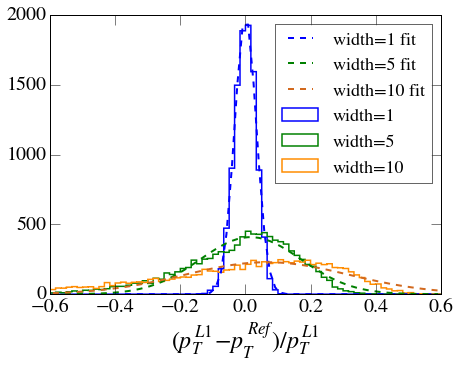

In [4]:
# plot the resolution hists
x_range=[-0.6,0.6]
nbins=72
y_1, bins_1, _ = plt.hist(res_1, bins=nbins, normed=False, range=x_range, 
                          label='width=1', histtype="step", linewidth=1.5)
y_5, bins_5, _ = plt.hist(res_5, bins=nbins, normed=False, color='green', range=x_range, 
                          label='width=5', histtype="step", linewidth=1.5)
y_10, bins_10, _ = plt.hist(res_10, bins=nbins, normed=False, color='darkorange', range=x_range, 
                            label='width=10', histtype="step", linewidth=1.5)

x = [0.5 * (bins_1[i]+bins_1[i+1]) for i in range(len(bins_1)-1)]
plt.xlabel(r'$(p_{T}^{L1} - p_{T}^{Ref})/p_{T}^{L1}$')
plt.xlim(x_range)

# fit with a Gaussian
def gaussian(x, a, b, c):
    val = a * np.exp(-(x - b)**2 / (2*(c**2)))
    return val

from scipy.optimize import curve_fit
popt_1, pcov_1 = curve_fit(gaussian, x, y_1)
popt_5, pcov_5 = curve_fit(gaussian, x, y_5)
popt_10, pcov_10 = curve_fit(gaussian, x, y_10)
plot(x, gaussian(x, *popt_1), lw=2, color='blue', ls='--', label='width=1 fit')
plot(x, gaussian(x, *popt_5), lw=2, color='green', ls='--', label='width=5 fit')
plot(x, gaussian(x, *popt_10), lw=2, color='chocolate', ls='--', label='width=10 fit')
plt.legend(loc=0, fontsize=18)
print 'width = 1: N:',popt_1[0], 'mean:', popt_1[1], 'sigma:', popt_1[2], 'should be:', 1/30.
print 'width = 5: N:',popt_5[0], 'mean:', popt_5[1], 'sigma:', popt_5[2], 'should be:', 5/30.
print 'width = 10: N:',popt_10[0], 'mean:', popt_10[1], 'sigma:', popt_10[2], 'should be:', 10/30.

So we see something interesting here:

- For a smaller width, the resolution is normally distributed

- For a larger width, the resolution looks less normal - more skewed towards smaller values of resolution (i.e. response  = L1/RefJet$\to 0$). The mean also deviates more from 0 at larger widths.

**So for worse inherent resolution (calibration?), plotting $(p_{T}^{L1} - p_{T}^{Ref})/p_{T}^{L1}$ becomse a bit useless for poor-resolution (or calibration?) jets.** (at least, for the purposes of trying to fit a Gaussian)

What about if we use the difference instead?

In [5]:
diff_1 = l1jets_1 - refjets
diff_5 = l1jets_5 - refjets
diff_10 = l1jets_10 - refjets

width = 1: N: 2369.52966074 mean: -0.00893985005172 sigma: -1.0140136573
width = 5: N: 474.160118362 mean: -0.00465389286339 sigma: -5.03649698811
width = 10: N: 238.748420299 mean: -0.0852899479751 sigma: -10.0686638568


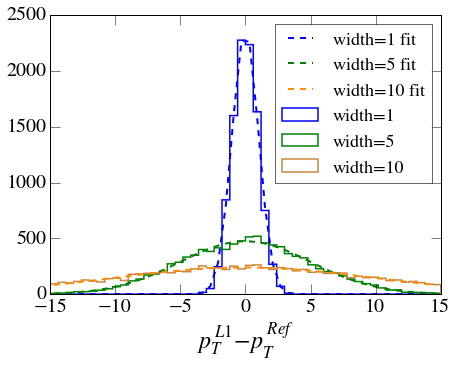

In [6]:
x_range=[-15,15]
nbins=50
y_1, bins_1, _ = plt.hist(diff_1, bins=nbins, normed=False, range=x_range, 
                          label='width=1', histtype="step", linewidth=1.5)
y_5, bins_5, _ = plt.hist(diff_5, bins=nbins, normed=False, color='green', range=x_range, 
                          label='width=5', histtype="step", linewidth=1.5)
y_10, bins_10, _ = plt.hist(diff_10, bins=nbins, normed=False, color='peru', range=x_range, 
                            label='width=10', histtype="step", linewidth=1.5)
x = [0.5 * (bins_1[i]+bins_1[i+1]) for i in range(len(bins_1)-1)]
plt.xlabel(r'$p_T^{L1} - p_T^{Ref}$')
popt_1, pcov_1 = curve_fit(gaussian, x, y_1)
popt_5, pcov_5 = curve_fit(gaussian, x, y_5)
popt_10, pcov_10 = curve_fit(gaussian, x, y_10)
plot(x, gaussian(x, *popt_1), lw=2, color='blue', ls='--', label='width=1 fit')
plot(x, gaussian(x, *popt_5), lw=2, color='green', ls='--', label='width=5 fit')
plot(x, gaussian(x, *popt_10), lw=2, color='darkorange', ls='--', label='width=10 fit')
plt.legend(fontsize=18, loc=0)
print 'width = 1: N:',popt_1[0], 'mean:', popt_1[1], 'sigma:', popt_1[2]
print 'width = 5: N:',popt_5[0], 'mean:', popt_5[1], 'sigma:', popt_5[2]
print 'width = 10: N:',popt_10[0], 'mean:', popt_10[1], 'sigma:', popt_10[2]

Let's divide the width by the mean pT. This should give use a more accurate value of the resolution, since our Gaussian fit is a better assumption.

In [7]:
for x,w in zip([popt_1, popt_5, popt_10],[1,2, 5,10]):
    print 'width =', w, 'fitted width/30 =', abs(x[2])/true_pt, " should be", w/true_pt

width = 1 fitted width/30 = 0.0338004552432  should be 0.0333333333333
width = 2 fitted width/30 = 0.167883232937  should be 0.0666666666667
width = 5 fitted width/30 = 0.335622128559  should be 0.166666666667


These are much closer to the actual value (the width of Gaussian / 30)

## With calibrations

In [38]:
# p0 = 3.32079045
# p1 = 30.10690152
# p2 = 2.91713150
# p3 = -206.73606994
# p4 = 0.00701027
# p5 = -20.22374281
# def pf_func(et, p0, p1, p2, p3, p4, p5):
#     return np.multiply(et, (p0 + (p1/(np.power(np.log10(et), 2)+p2)) + p3 * np.exp(-1.*p4*np.power(np.log10(et)-p5, 2))))
# l1jets_1_corr = pf_func(l1jets_1, p0, p1, p2, p3, p4, p5)
# l1jets_5_corr = pf_func(l1jets_5, p0, p1, p2, p3, p4, p5)
# l1jets_10_corr = pf_func(l1jets_10, p0, p1, p2, p3, p4, p5)

In [39]:
# plt.hist(l1jets_1_corr, bins=50, alpha=0.3, range=[10,60], normed=False, label='width=1')
# plt.hist(l1jets_5_corr, bins=50, alpha=0.3, color='green', range=[10,60], normed=False, label='width=5')
# plt.hist(l1jets_10_corr, bins=50, alpha=0.3, color='orange', range=[10,60], normed=False, label='width=10')
# plt.xlabel(r"$p_T^{L1}$")
# plt.minorticks_on()
# plt.tight_layout()
# plt.legend(loc=0)

In [40]:
# # calculate resolution = (L1 - ref )/ L1 = 1 - (ref/L1)
# # refjets = np.array([true_pt]*N)
# res_1_corr = np.ones(N)-np.divide(refjets, l1jets_1_corr)
# res_5_corr = np.ones(N)-np.divide(refjets, l1jets_5_corr)
# res_10_corr = np.ones(N)-np.divide(refjets, l1jets_10_corr)

In [41]:
# # plot the resolution hists
# y_1_corr, bins_1_corr, _ = plt.hist(res_1_corr, bins=60, normed=False, alpha=0.3, range=[-0.1,0.5], label='width=1')
# y_5_corr, bins_5_corr, _ = plt.hist(res_5_corr, bins=60, normed=False, alpha=0.3, color='green', range=[-0.1,0.5], label='width=5')
# y_10_corr, bins_10_corr, _ = plt.hist(res_10_corr, bins=60, normed=False, alpha=0.4, color='orange', range=[-0.1,0.5], label='width=10')

# x = [0.5 * (bins_1_corr[i]+bins_1_corr[i+1]) for i in range(len(bins_1_corr)-1)]
# plt.xlabel(r'$(p_{T}^{L1} - p_{T}^{Ref})/p_{T}^{L1}$')
# plt.legend(loc=0)
# # plt.yscale('log')
# # plt.ylim(bottom=2E1, top=3E3)
# # plt.xlim(-0.6,0.3)

# # fit with a Gaussian
# def gaussian(x, a, b, c):
#     val = a * np.exp(-(x - b)**2 / (2*(c**2)))
#     return val

# from scipy.optimize import curve_fit
# popt_1_corr, pcov_1_corr = curve_fit(gaussian, x, y_1_corr)
# popt_5_corr, pcov_5_corr = curve_fit(gaussian, x, y_5_corr)
# popt_10_corr, pcov_10_corr = curve_fit(gaussian, x, y_10_corr)
# plot(x, gaussian(x, *popt_1_corr), lw=1, color='blue', ls='--')
# plot(x, gaussian(x, *popt_5_corr), lw=1, color='green', ls='--')
# plot(x, gaussian(x, *popt_10_corr), lw=1, color='darkorange', ls='--')
# print 'width = 1: N:',popt_1_corr[0], 'mean:', popt_1_corr[1], 'sigma:', popt_1_corr[2], 'should be:', 1/30.
# print 'width = 5: N:',popt_5_corr[0], 'mean:', popt_5_corr[1], 'sigma:', popt_5_corr[2], 'should be:', 5/30.
# print 'width = 10: N:',popt_10_corr[0], 'mean:', popt_10_corr[1], 'sigma:', popt_10_corr[2], 'should be:', 10/30.

## Bit more realistic

Let's repeat, but instead of a single ref jet value, we'll have a uniform ref jet distribution over 14 - 22 GeV:

In [8]:
# N = 10000
# refjets2 = np.random.uniform(14,22,N)
# # print np.random.normal(20,1,1)
# l1jets2_1 = np.array([np.random.normal(pt, scale=1, size=1)[0] for pt in refjets2])
# l1jets2_5 = np.array([np.random.normal(pt, scale=5, size=1)[0] for pt in refjets2])
# l1jets2_10 = np.array([np.random.normal(pt, scale=10, size=1)[0] for pt in refjets2])

In [9]:
# plt.hist(l1jets2_1, bins=50, alpha=0.3, range=[0,40], label='width=1')
# plt.hist(l1jets2_5, bins=50, alpha=0.3, color='green', range=[0,40], label='width=5')
# plt.hist(l1jets2_10, bins=50, alpha=0.3, color='orange', range=[0,40], label='width=10')
# plt.xlabel(r"$p_T^{L1}$")
# plt.minorticks_on()
# plt.tight_layout()
# plt.legend()

Let's do the same experiment - first our 'standard' resolution:

In [10]:
# # calculate resolution = (L1 - ref )/ L1 = 1 - (ref/L1)
# res2_1 = np.ones(N)-np.divide(refjets2, l1jets2_1)
# res2_5 = np.ones(N)-np.divide(refjets2, l1jets2_5)
# res2_10 = np.ones(N)-np.divide(refjets2, l1jets2_10)

In [11]:
# # plot the resolution hists
# y2_1, bins2_1, patches2_1 = plt.hist(res2_1, bins=50, normed=False, alpha=0.3, range=[-1,0.6], label='width=1')
# y2_5, bins2_5, patches2_5 = plt.hist(res2_5, bins=50, normed=False, alpha=0.3, color='green', range=[-1,0.6], label='width=5')
# y2_10, bins2_10, patches2_10 = plt.hist(res2_10, bins=50, normed=False, alpha=0.4, color='darkorange', range=[-1,0.6], label='width=10')

# x = [0.5 * (bins2_1[i]+bins2_1[i+1]) for i in range(len(bins2_1)-1)]
# plt.xlabel(r'$(p_{T}^{L1} - p_{T}^{Ref})/p_{T}^{L1}$')
# plt.legend(loc=0)
# # plt.yscale('log')
# # plt.ylim(bottom=2E1, top=3E3)
# plt.xlim(-1,0.6)

# # fit with a Gaussian
# def gaussian(x, a, b, c):
#     val = a * np.exp(-(x - b)**2 / (2*(c**2)))
#     return val

# from scipy.optimize import curve_fit
# popt2_1, pcov2_1 = curve_fit(gaussian, x, y2_1)
# popt2_5, pcov2_5 = curve_fit(gaussian, x, y2_5)
# popt2_10, pcov2_10 = curve_fit(gaussian, x, y2_10)
# plot(x, gaussian(x, *popt2_1), lw=1, color='blue', ls='--')
# plot(x, gaussian(x, *popt2_5), lw=1, color='green', ls='--')
# plot(x, gaussian(x, *popt2_10), lw=2, color='darkorange', ls='--')
# print 'width = 1: N:',popt2_1[0], 'mean:', popt2_1[1], 'sigma:', popt2_1[2], 'should be:', 1./np.mean(refjets2)
# print 'width = 5: N:',popt2_5[0], 'mean:', popt2_5[1], 'sigma:', popt2_5[2], 'should be:', 5./np.mean(refjets2)
# print 'width = 10: N:',popt2_10[0], 'mean:', popt2_10[1], 'sigma:', popt2_10[2], 'should be:', 10./np.mean(refjets2)

So again, we can see that for small inherent widths, the quantity is sensible. But for larger widths, it starts to become skewed. Let's try the same trick, just fitting the pt difference.

In [12]:
# diff2_1 = l1jets2_1 - refjets2
# diff2_5 = l1jets2_5 - refjets2
# diff2_10 = l1jets2_10 - refjets2

In [13]:
# y2_1, bins2_1, patches2_1 = plt.hist(diff2_1, bins=60, normed=False, alpha=0.3, range=[-10,10], label='width=1')
# y2_5, bins2_5, patches2_5 = plt.hist(diff2_5, bins=60, normed=False, alpha=0.3, color='green', range=[-10,10], label='width=5')
# y2_10, bins2_10, patches2_10 = plt.hist(diff2_10, bins=60, normed=False, alpha=0.3, color='orange', range=[-10,10], label='width=10')
# x = [0.5 * (bins2_1[i]+bins2_1[i+1]) for i in range(len(bins2_1)-1)]
# plt.xlabel(r'$p_T^{L1} - p_T^{Ref}$')
# popt2_1, pcov2_1 = curve_fit(gaussian, x, y2_1)
# popt2_5, pcov2_5 = curve_fit(gaussian, x, y2_5)
# popt2_10, pcov2_10 = curve_fit(gaussian, x, y2_10)
# plot(x, gaussian(x, *popt2_1), lw=2, color='blue', ls='--')
# plot(x, gaussian(x, *popt2_5), lw=2, color='green', ls='--')
# plot(x, gaussian(x, *popt2_10), lw=2, color='darkorange', ls='--')
# plt.legend()
# print 'width = 1: N:',popt2_1[0], 'mean:', popt2_1[1], 'sigma:', popt2_1[2]
# print 'width = 5: N:',popt2_5[0], 'mean:', popt2_5[1], 'sigma:', popt2_5[2]
# print 'width = 10: N:',popt2_10[0], 'mean:', popt2_10[1], 'sigma:', popt2_10[2]

Again, we take the fitted mean and divide by the mean of the ref jets

In [14]:
# from itertools import product, izip
# for x,j,w in izip([popt2_1, popt2_5, popt2_10], [l1jets2_1, l1jets_5, l1jets_10], [1,5,10]):
#     print 'width =', w, 'fitted width/<ref jets> =', abs(x[2])/np.mean(refjets2), " should be", w/np.mean(refjets2)
#     print 'width =', w, 'fitted width/<l1 jets> =', abs(x[2])/np.mean(j), " should be", w/np.mean(j)

So it appears that if we want to reconstruct the inherent resolution, we should really divide by the average ref jet pT